In [1]:
import torch
from torch import nn
from pathlib import Path
import numpy as np
import seaborn as sns
import scipy.io as spio
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# plt.style.use('dark_background')

from modules.elbo import ELBO

import os

### Setup parameters

In [2]:
# load sample trajectory
sim_idx = 0 # which out of the 100 trajectories to use
data_path = Path('data')
f_name = 'sim_0040.mat'
S = spio.loadmat(Path(data_path) / f_name)['S']
S_list = [S[0, i] for i in range(S.shape[1])]  # convert to list of structs

# unpack data
n_corr_obs = S_list[sim_idx]['Pc_reshaped'][0, 0] * S_list[sim_idx]['num_trials_mat'][0, 0]
n_total_obs = S_list[sim_idx]['num_trials_mat'][0, 0]
n_frames = S_list[sim_idx]['Pc_reshaped'][0, 0].shape[0]
# n_dim = S_list[sim_idx]['x'][0, 0].shape[0]
n_dim = 10
c_true = S_list[sim_idx]['generative_params'][0][0]['c_mu'][0][0][0]

In [3]:
c_true

array([140], dtype=uint8)

### Run inference

In [4]:
elbo = ELBO(n_dim, n_corr_obs, n_total_obs, n_starts=10, n_iterations=30000, lr=1e-4)
x, p, errors, kl_loss, ll_loss, c_prior, d_prior, l_prior, c_post, d_post, l_post = elbo.optimize_ELBO_SGD()

Running MLE to initialize posterior..........................
Iteration 1 | Loss: 854.7501490041614
Current loss: 938.4679716005921
Loss updated
Iteration 2 | Loss: 938.4679716005921
Current loss: 746.9648397117853
Loss updated
Iteration 3 | Loss: 746.9648397117853
Current loss: 870.5799797996879
Iteration 4 | Loss: 870.5799797996879
Current loss: 823.3771319389343
Iteration 5 | Loss: 823.3771319389343
Current loss: 841.7497110590339
Iteration 6 | Loss: 841.7497110590339
Current loss: 906.9384290501475
Iteration 7 | Loss: 906.9384290501475
Current loss: 886.7653607204556
Iteration 8 | Loss: 886.7653607204556
Iteration 9 | Loss: 867.2020023912191
Iteration 10 | Loss: 773.7440826445818
Epoch: 0, Loss: 1160.1627457903764
Epoch: 250, Loss: 1114.3708177474944
Epoch: 500, Loss: 1081.7245239056665
Epoch: 750, Loss: 1043.6508471719221
Epoch: 1000, Loss: 1020.9369522104871
Epoch: 1250, Loss: 991.8573298327432
Epoch: 1500, Loss: 975.9199767297309
Epoch: 1750, Loss: 959.3510046730315
Epoch: 2000,

#### Load final model and plot error curves

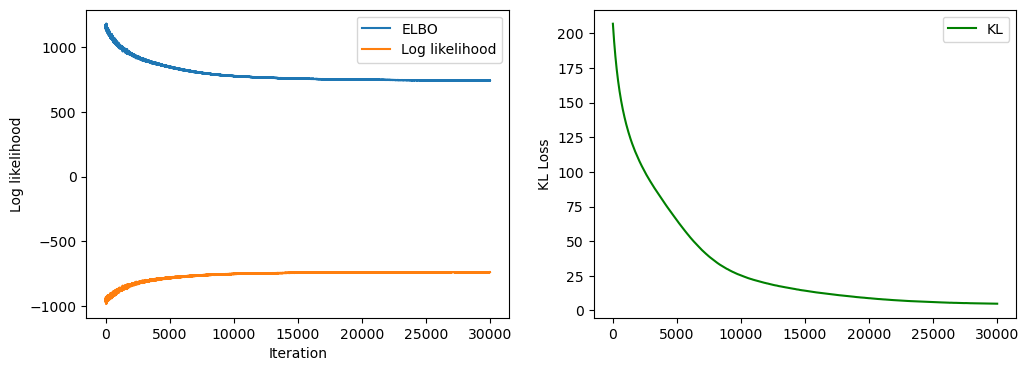

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Primary y-axis (ELBO and Neg. log likelihood)
axs[0].plot(errors, label='ELBO')
axs[0].plot(ll_loss, label='Log likelihood')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Log likelihood')
# axs[0].set_yscale('log')
# axs[0].tick_params(axis='y')

axs[1].plot(kl_loss, label='KL', color='green')
axs[1].set_ylabel('KL Loss')
# axs[1].tick_params(axis='y')
# axs[1].set_yscale('log')

# Add legends for both axes
axs[0].legend()
axs[1].legend()

# save and show the plot
# fig.suptitle('Loss over iterations')
# plt.savefig(Path(out_dict) / f"error_{sim_curvature}")
# plt.show()

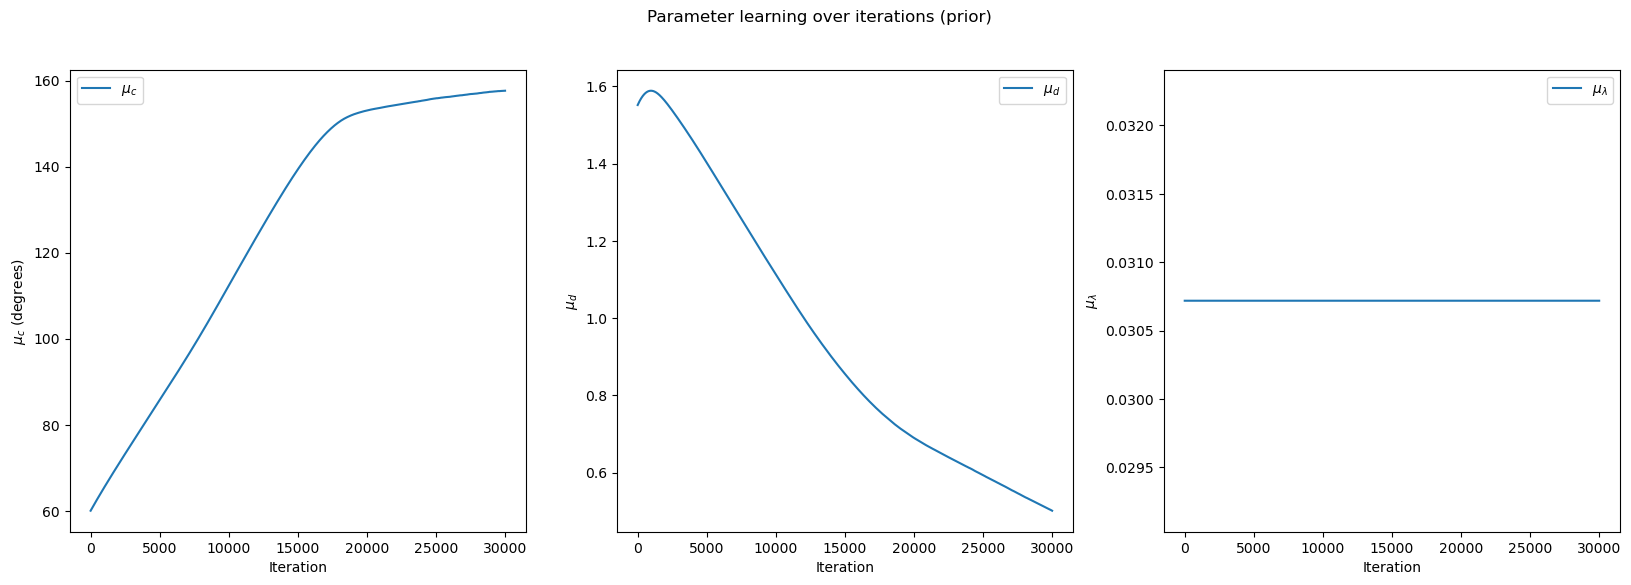

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(c_prior, label=r'$\mu_c$')
axs[0].set_ylabel(r'$\mu_{c}$ (degrees)')

axs[1].plot(d_prior, label=r'$\mu_d$')
axs[1].set_ylabel(r'$\mu_{d}$')

axs[2].plot(l_prior, label=r'$\mu_{\lambda}$')
axs[2].set_ylabel(r'$\mu_{\lambda}$')

for i in range(3):
    axs[i].legend()
    axs[i].set_xlabel('Iteration')

fig.suptitle('Parameter learning over iterations (prior)')
plt.show()

/var/folders/56/7xrzykp553j4850_g_vdc8mr0000gn/T/ipykernel_47645/2295650332.py:9: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3729.)
  axs[2].plot(l_post.T)


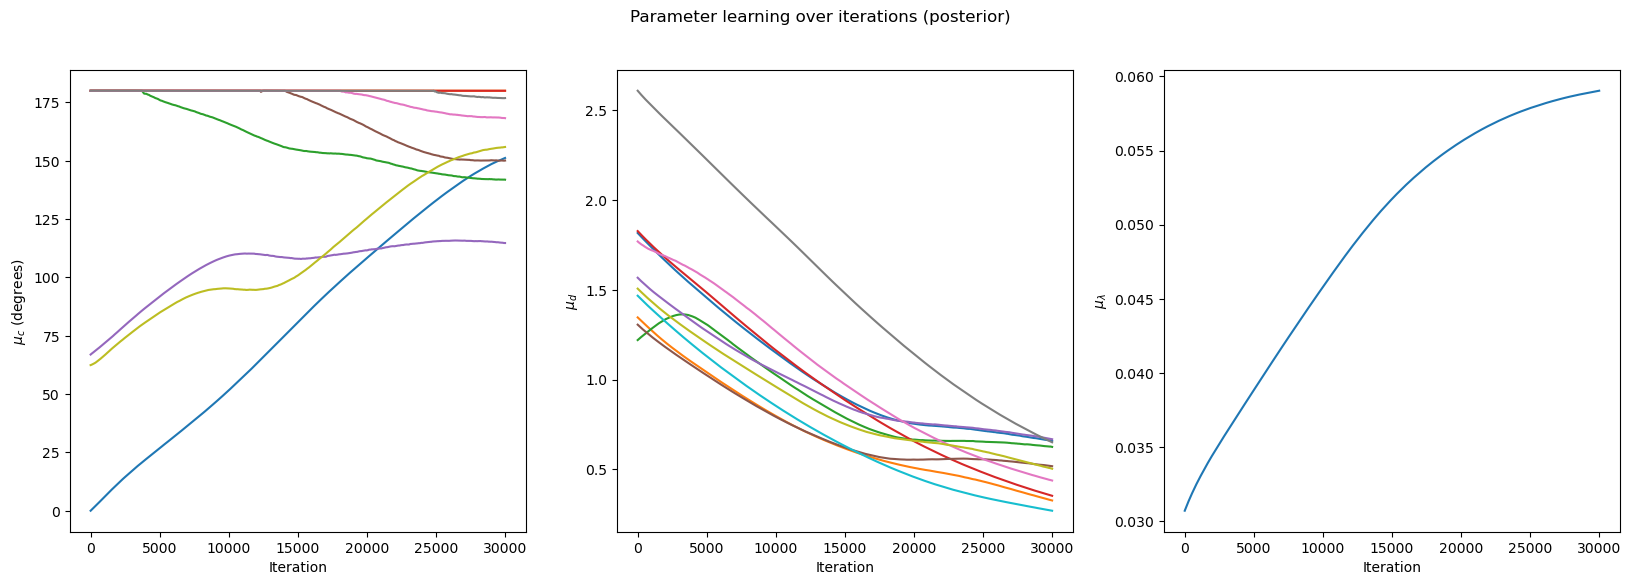

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(c_post.T)
axs[0].set_ylabel(r'$\mu_{c}$ (degrees)')

axs[1].plot(d_post.T)
axs[1].set_ylabel(r'$\mu_{d}$')

axs[2].plot(l_post.T)
axs[2].set_ylabel(r'$\mu_{\lambda}$')

for i in range(3):
    axs[i].set_xlabel('Iteration')

fig.suptitle('Parameter learning over iterations (posterior)')
plt.show()

### Reconstruct trajectory

In [8]:
est_global_curvature = torch.rad2deg(elbo.mu_prior_c.detach())
print(f'Estimated global curvature: {est_global_curvature} degrees')
print(f'Average estimated local curvature: {torch.rad2deg(torch.mean(elbo.mu_post_c).detach())} degrees')

Estimated global curvature: 157.6575927734375 degrees
Average estimated local curvature: 157.92079743178982 degrees


In [9]:
# compute PC-reduced perceptual locations
pca_true = PCA(n_components=2)
pca_fit = PCA(n_components=2)

# ground truth perceptual locations
pca_true.fit(S_list[sim_idx]['x'][0, 0])
pc_true = pca_true.components_

pca_fit.fit(x.squeeze().detach())
pc_fit = pca_fit.components_

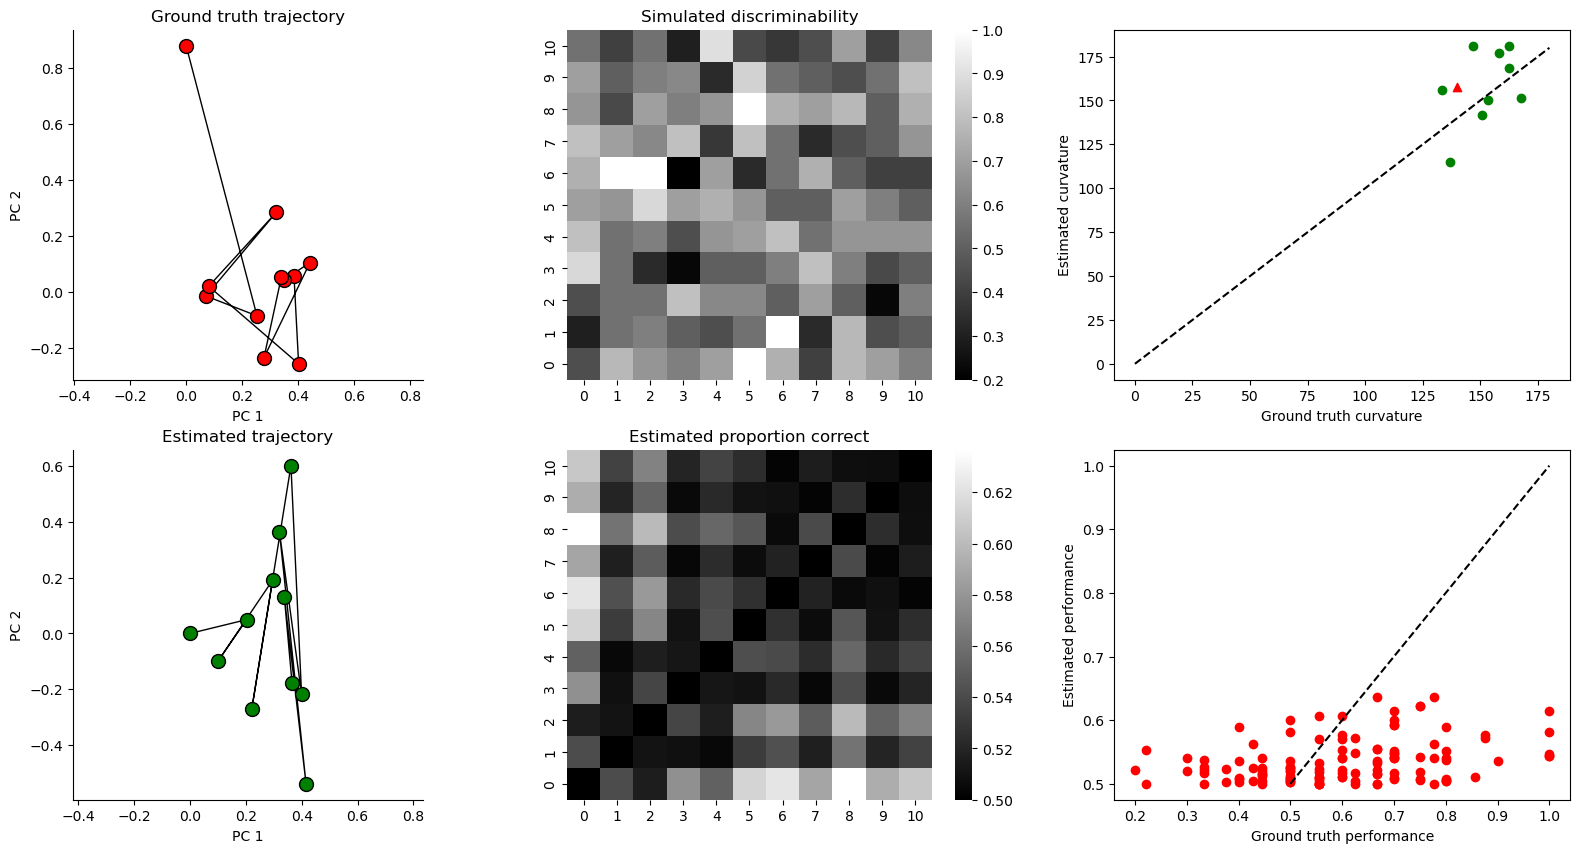

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs[0, 0].plot(pc_true[0, :], pc_true[1, :], '-ko', markersize=10, markerfacecolor='r', linewidth=1)
axs[0, 0].set_title('Ground truth trajectory')
axs[0, 0].set_xlabel('PC 1')
axs[0, 0].set_ylabel('PC 2')
axs[0, 0].set_box_aspect(1)  
axs[0, 0].set_aspect('equal') 
axs[0, 0].spines['top'].set_visible(False)  
axs[0, 0].spines['right'].set_visible(False)

sns.heatmap(S_list[sim_idx]['Pc_reshaped'][0, 0], ax=axs[0, 1], cmap='gray')
axs[0, 1].invert_yaxis()
axs[0, 1].set_title('Simulated discriminability')

axs[0, 2].plot(np.rad2deg(S_list[sim_idx]['c'][0, 0]).flatten(), torch.flatten(torch.rad2deg(elbo.mu_post_c)).detach(), 'go')
axs[0, 2].plot([0, 180], [0, 180], 'k--')
axs[0, 2].scatter(c_true, torch.rad2deg(torch.mean(elbo.mu_post_c.detach())), marker='^', c='red')
axs[0, 2].set_xlabel('Ground truth curvature')
axs[0, 2].set_ylabel('Estimated curvature')

axs[1, 0].plot(pc_fit[0, :], pc_fit[1, :], '-ko', markersize=10, markerfacecolor='g', linewidth=1)
axs[1, 0].set_title('Estimated trajectory')
axs[1, 0].set_xlabel('PC 1')
axs[1, 0].set_ylabel('PC 2')
axs[1, 0].set_box_aspect(1)  
axs[1, 0].set_aspect('equal') 
axs[1, 0].spines['top'].set_visible(False)  
axs[1, 0].spines['right'].set_visible(False)

sns.heatmap(p.detach().squeeze(), ax=axs[1, 1], cmap='gray')
axs[1, 1].invert_yaxis()
axs[1, 1].set_title('Estimated proportion correct')

axs[1, 2].plot(S_list[sim_idx]['Pc_reshaped'][0, 0].flatten(), p.flatten().detach(), 'ro')
axs[1, 2].plot([0.5, 1], [0.5, 1], 'k--')
axs[1, 2].set_xlabel('Ground truth performance')
axs[1, 2].set_ylabel('Estimated performance')

plt.show()

In [11]:
# save data
import pickle 

save_data = {'x_true': S_list[sim_idx]['x'][0, 0],
             'x_pred': x,
             'perf_true': S_list[sim_idx]['Pc_reshaped'][0, 0],
             'perf_pred': p.detach().squeeze(),
             'c_true_sim': np.rad2deg(S_list[sim_idx]['c'][0, 0]).flatten(), 
             'c_post': torch.flatten(torch.rad2deg(elbo.mu_post_c)).detach(),
             'c_true': c_true}

# f_name = Path('data') / 'curvatures' / f'curvature_{str(i+1).zfill(4)}.pkl'
f_name = Path('data') / 'curvatures' / f'curvature_0003.pkl'
with open(f_name, 'wb') as f:
    pickle.dump(save_data, f)

In [12]:
# with open(f_name, 'rb') as f:
#     loaded_dict = pickle.load(f)